In [2]:
import pandas as pd

# Read the CSV
df=pd.read_csv('result-2016-02-02-00-00-07.csv', sep=',')

In [14]:
import random
import numpy as np
random.seed(9001)

# Data cleanup
def cleanData(df):
    # remove cars without manufactures date
    cleaned = df[pd.isnull(df['manufactured']) == False]
    # remove cars without km
    cleaned = cleaned[cleaned['km'] > 10]
    # remove cars without brand
    cleaned = cleaned[pd.isnull(cleaned['brand']) == False]
    # remove cars without price
    cleaned = cleaned[pd.isnull(cleaned['price']) == False]
    # remove free cars
    cleaned = cleaned[cleaned['price'] > 1000]
    # Get manufacture year
    cleaned = cleaned.assign(manYear = [d.year for d in pd.to_datetime(cleaned['manufactured'], format="%Y-%m-%d")])
    # Get type = brand+Model
    cleaned = cleaned.assign(carType = cleaned['brand'] + cleaned['model'].replace(np.nan,' ', regex=True))
    # Get rid of old cars
    cleaned = cleaned[cleaned['manYear'] > 1990]
    # Get rid of other fuel
    cleaned = cleaned[cleaned['fuel'] != 'OTHER']
    # Get rid of cabriolet and van (not in the training data, should be changed later)
    cleaned = cleaned[cleaned['carosery'] != 'CABRIOLET']
    cleaned = cleaned[cleaned['carosery'] != 'VAN']
    cleaned = cleaned[cleaned['carosery'] != 'COUPE']
    # 1M km? Really?
    cleaned = cleaned[cleaned['km'] < 1000000]
    # 10l cubature? Really?
    cleaned = cleaned[cleaned['cubicCapacity'] < 10000]

    #shuffle
    cleaned = cleaned.reindex(np.random.permutation(cleaned.index))
    return cleaned

cleaned = cleanData(df)

print(cleaned.shape)

(44603, 67)


In [17]:
from sklearn import preprocessing
import scipy
   
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore') # I am not able to install correct version of libraries

# Combination of labelEncoder and oneHotEncoder. Will be stored for later use
class LabelOneHotEncoder:
    def __init__(self, labelEncoder, oneHotEncoder):
        self.labelEncoder = labelEncoder
        self.oneHotEncoder = oneHotEncoder
    
    def transform(self, data):
        labels = self.labelEncoder.transform(data).reshape(-1, 1)
        return self.oneHotEncoder.transform(labels)

def encodeCategory(data):
    labelEncoder = preprocessing.LabelEncoder()
    labels = labelEncoder.fit_transform(data).reshape(-1, 1)

    oneHotEncoder = preprocessing.OneHotEncoder()
    oneHot = oneHotEncoder.fit_transform(labels)
    return oneHot, LabelOneHotEncoder(labelEncoder, oneHotEncoder)

def getColumn(data, name):
    return data[name].reshape(-1, 1)

def normalize(data):
    normalizer = preprocessing.RobustScaler(with_centering=False)
    return normalizer.fit_transform(data), normalizer

def binarize(data):
    binarizer = preprocessing.LabelBinarizer()
    return binarizer.fit_transform(data)


# Model for given car type
class Model:
    def __init__(self):
        self.trained = False
    
    # Mostly data normalization and transformation
    def _createFeatures(self, data):
        firstOwner = binarize(getColumn(data, 'firstOwner'))
        serviceHistory = binarize(getColumn(data, 'serviceHistory'))
        czech = binarize(getColumn(data, 'originCountry')=='CZ')
        clima = binarize(getColumn(data, 'clima')!='NO')
        
        km = getColumn(data, 'km')
        manYear = getColumn(data, 'manYear')
        
        if not self.trained:
            # store encoders
            carosery, self.caroseryEncoder = encodeCategory(data['carosery'])
            fuel, self.fuelEncoder = encodeCategory(data['fuel'])
            gearBox, self.gearBoxEncoder = encodeCategory(data['gearBox'])
            
            # store normalizers
            km, self.kmNormalizer = normalize(km)
            manYear, self.manYearNormalizer = normalize(manYear)
            cubicCapacity, self.cubicCapacityNormalizer = normalize(getColumn(data, 'cubicCapacity'))
        else:
            carosery = self.caroseryEncoder.transform(getColumn(data, 'carosery'))
            fuel = self.fuelEncoder.transform(getColumn(data, 'fuel'))
            gearBox = self.gearBoxEncoder.transform(getColumn(data, 'gearBox'))
            
            km = self.kmNormalizer.transform(km)
            manYear = self.manYearNormalizer.transform(manYear)
            cubicCapacity = self.cubicCapacityNormalizer.transform(getColumn(data, 'cubicCapacity'))
        
        return scipy.sparse.hstack((km, manYear, cubicCapacity, firstOwner, serviceHistory, czech, clima, carosery, fuel, gearBox)).toarray()
        #return np.hstack((km, manYear, cubicCapacity, firstOwner, serviceHistory, czech, clima))
    
    # Trains the model
    def train(self, data):
        assert self.trained == False
        features = self._createFeatures(data)
        
        # Log price is much beter for linear models
        price = np.log(getColumn(data, 'price'))
    
        self.model = Ridge()
        #self.model = LinearRegression()
        #self.model = SVR(kernel='linear')
        #self.model = SVR()
        self.trained = True
        self.model.fit(features, price)
    
    def predict(self, data):
        assert self.trained == True
        features = self._createFeatures(data)
        
        # Prediction is exp of log price
        return np.exp(self.model.predict(features))

# Models for all car types
class ModelsForTypes:
    def __init__(self):
        self.models = {}
        self.trained = False
    
    def train(self, data):
        assert self.trained == False
        for carType in data['carType'].unique():
            dataForType = data[data['carType'] == carType]        
            #at least three samples for the type
            if (len(dataForType)>3):            
                model = Model()
                model.train(dataForType)
                self.models[carType] = model
            self.trained = True
            
    def predict(self, data):
        assert self.trained == True
        # Prediction works type by type
        for carType in data['carType'].unique():
            if carType in self.models:
                model = self.models[carType]
                dataForType = data[data['carType'] == carType]
                try:
                    pred = model.predict(dataForType)
                    #print("%s %s %s" % (carType, len(dataForType), mean_absolute_error(dataForType['price'], pred)))
                    data.at[dataForType.index, 'pred'] = pred
                    break
                except ValueError as e:
                    print('Can not predict for %s %s' % (carType, e.strerror))
                    data.at[dataForType.index, 'pred'] = float('NaN')
            # We do not have model for the car
            else:
                data.at[dataForType.index, 'pred'] = float('NaN')
        
                
models = ModelsForTypes()
print('Training')
models.train(cleaned)
print('Predicting')
models.predict(cleaned)
print('Finished')

def printAccuracy(data):
    dataWithPred = data[np.isfinite(data['pred'])]
    diff = np.abs(dataWithPred['price'] - dataWithPred['pred'])
    print(np.mean(diff))            
    print(np.median(diff))            
    print(np.percentile(diff, 90)) 
    
printAccuracy(cleaned)

Training
Predicting
Finished
28278.9538511
14075.8818487
61316.1416988


In [170]:
# Store the results (only those with prediction)
cleaned[np.isfinite(cleaned['pred'])].to_csv('cleaned.csv')

In [19]:
# validaton on different data
validation=pd.read_csv('result-2016-03-06-00-00-08.csv', sep=',')
cleanedValidation = cleanData(validation)
print(cleanedValidation.shape)
models.predict(cleanedValidation)
printAccuracy(cleanedValidation)

(45912, 67)
26965.6359512
19713.5554876
57138.5042138


In [156]:
#(km, manYear, cubicCapacity, firstOwner, serviceHistory, czech, clima, carosery, fuel, gearBox)
m = models.models['ŠkodaOctavia']
print("Const: %s" % (m.model.intercept_))

kmTr = m.kmNormalizer.transform(np.power([10000], 0.2))
print("Subtract for km: %s" % (kmTr * m.model.coef_[0,0]))

# Years since 1990
manYearTr = m.manYearNormalizer.transform(np.power([25], 3))
print("Add for manYear: %s" % (manYearTr * m.model.coef_[0,1]))

print(m.model.intercept_ + kmTr * m.model.coef_[0,0] + manYearTr * m.model.coef_[0,1])

Const: [ 202707.32175131]
Subtract for km: [-200058.05918774]
Add for manYear: [ 340999.52021655]
[ 343648.78278012]


In [158]:
print(models.models['ŠkodaOctavia'].model.intercept_)

models.models['ŠkodaOctavia'].model.coef_[0]

[ 203734.86799099]


array([ -52180.44087926,  158471.90772189,   46958.5881042 ,
         -3124.61919278,    7286.52059244,    6528.0569068 ,
        -16278.94951053,   -9986.73673536,    9233.81332917,
         -2461.74014591,    3214.66355272,  -13375.83587792,
         24107.74954126,  -10731.91366321,   34029.58983769,
        -15723.9292904 ,  -18305.66054721])

In [131]:
models.models['ŠkodaOctavia'].caroseryEncoder.transform(cleaned[cleaned['carType']=='ŠkodaOctavia']['carosery']).toarray()

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]])

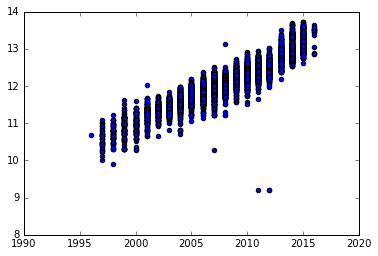

In [165]:
plt.scatter(oktavky['manYear'], np.log(oktavky['price']))